<a href="https://colab.research.google.com/github/pjbenard/MPEG/blob/main/JPEG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Format de compression MPEG

Pierre-Jean Bénard, Mikael El Ouazzani, Paul Larousse, Manon Leclère, 5GMM MMN

Notre projet consiste en l'implémentation du format compression MPEG,  Moving Picture Experts Group. 
Le projet est divisé en deux parties : la compression JPEG et le "flot optique".

## Introduction

On dispose d'une séquence vidéo que l'on souhaite compresser. Le standard MPEG propose la solution suivante pour la partie encodage :
* Sur une seconde de vidéo, soit 24 images, on sélectionne 3 images dîtes de réferences, que l'on compresse au format JPEG.
* Les autres images de la séquence sont compressées à l'aide d'un algorithme d'estimation de mouvement. 


## I. Compression JPEG

La compression JPEG (Joint Photographic Experts Group) est un processus qui permet de réduire la taille d'une image 

Le processus de compression comporte six étapes principales :

1. Transformation de couleurs
2. Sous échantillonnage
3. Découpage en blocs de pixels
4. DCT
5. Quantification
6. Codage RLE et Huffman 

## II. Estimation de mouvement

Formellement on veut résoudre le problème d'optimisation suivant :

[inserer equation]

Le schéma global de résolution peut être résumé de la sorte :
1. Découpage de l'image de référence (au temps t) et de l'image à prédire (au temps t+1) en macrobloc.
2. Définition d'une zone de recherche autours des macroblocs dans l'image de réference.
3. Parcours des macrobloc de l'image à prédire et calcul de la similarité pour différentes positions à l'intérieur de la zone de recherche
4. Calcul de la position donnant le maximum de similarité pour chacun des macrobloc


### Importation des librairies

In [1]:
import numpy as np
import scipy as sp
import scipy.fftpack as fft

from itertools import product

#from bokeh.plotting import figure, show
#from bokeh.io import output_notebook
#import holoviews as hv
#hv.config.enable_colab_support = True
#hv.extension('bokeh')

import matplotlib.pyplot as plt

from PIL import Image
import requests
from io import BytesIO

Chargement de l'image. On a le choix entre l'image 'RGB_illumination.jpg' ou 'montagne.jpg'.

In [2]:

#img_url = "https://upload.wikimedia.org/wikipedia/commons/2/28/RGB_illumination.jpg"
#response = requests.get(img_url)
#img = np.array(Image.open(BytesIO(response.content))).astype(int)

img = np.array(Image.open('images_notebook/montagne.jpg'))

In [3]:
img.shape

(3456, 4608, 3)

Affichage de l'image et des channels

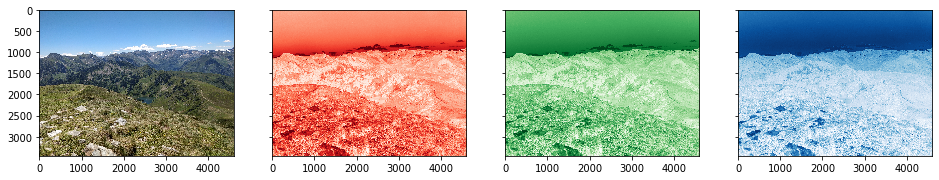

In [8]:
def plot_img_channels(img, cmaps=['Reds', 'Greens', 'Blues']):
    fig, axs = plt.subplots(1, 4, figsize=(16, 3), sharey=True, sharex=True)
    axs[0].imshow(img.astype(int))

    for col, cmap in enumerate(cmaps):
        axs[col + 1].imshow(img[..., col], cmap=cmap)

    plt.show()

plot_img_channels(img)

In [9]:
def plot_compare_imgs(*imgs):
    nb_imgs = len(imgs)
    fig, axs = plt.subplots(1, nb_imgs, figsize=(16, 16 // nb_imgs), sharex=True, sharey=True)
    
    for idx, img in enumerate(imgs):
        axs[idx].imshow(img.astype(int))
        
    plt.show()

### 1. Transformation des couleurs

D'abord on va transformer les couleurs de l'image.
Les codages de couleur type luminance/chrominance donnent les meilleurs taux de compression car l'oeil humain assez sensible à la luminosité (luminance, Y) mais peu à la teinte (chrominance, Cb Cr) d'une image. La figure suivante illustre cette sensibilité : le vert est le mieux perçu, puis le rouge et le bleu de manière minoritaire. 

![Perception](images_notebook/perception.png)

C'est "moins grave" de sous échantillonner sur les couleurs type luminance/chrominance. On passera donc d'une image codée en RGB à une image codée en fonction de sa luminance, et de sa chrominance(format YCbCr ou YUV).



Passer des channels RGB aux channels YUV consiste à faire un changement de base orthogonale (rappel : la base de RGB est orthogonale)

En principe, on a en quelque sorte :

  $$  Y ≃ R + G + B \\
    U ≃ B – Y \\
    V ≃ R – Y$$
    
La matrice de changement de base est plus particulièrement définie ainsi : (Wikipédia + autres sources)

![Changement](images_notebook/changement_base.png)

Ici, on utilise simplement une fonction du module Image de la librairie PIL.

Implémentation de RGB_to_YCbCr

In [10]:
def RGB_to_YCbCr(img_rgb):
    # 1.3 s ± 10.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
    conv = np.array([[ 65.481, 128.553,  24.966], 
                     [-37.797, -74.203, 112.   ], 
                     [112.   , -93.786, -18.214]])
    
    img_ycbcr = np.dot(img_rgb.astype(float)/255, conv.T)
    img_ycbcr[:,:,0] += 16
    img_ycbcr[:,:,[1,2]] += 128
    return img_ycbcr.astype(int)

def RGB_to_YCbCr_v2(img_rgb):
    # 123 ms ± 1.31 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
    return np.array(Image.fromarray(img_rgb).convert('YCbCr'))
    
def YCbCr_to_RGB(img_ycbcr):
    # 1.34 s ± 15.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
    conv = np.array([[1,  0      , 1.402  ], 
                     [1, -0.34414, -.71414], 
                     [1,  1.772  , 0      ]])

    img_rgb = img_ycbcr.astype(float)
    img_rgb[:,:,[1,2]] -= 128
    img_rgb = np.dot(img_rgb, conv.T)
    
    return np.clip(img_rgb, 0, 255).astype(int)

def YCbCr_to_RGB_v2(img_ycbcr):
    # 93.3 ms ± 618 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
    pre_img = np.clip(img_ycbcr, 0, 255).astype(np.uint8)
    return np.array(Image.fromarray(pre_img, mode='YCbCr').convert('RGB'))

Ici, on observe l'image et les trois channels après le changement de base :

(3456, 4608, 3)


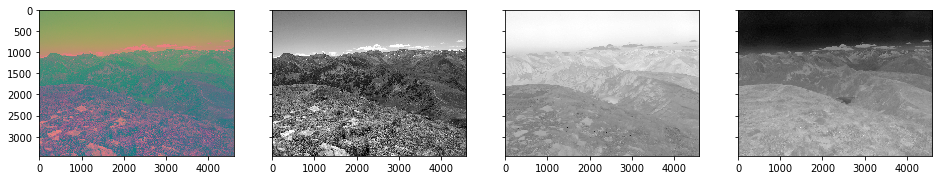

In [11]:
img_ycbcr = RGB_to_YCbCr(img)
print(img_ycbcr.shape)
plot_img_channels(img_ycbcr, ['gray'] * 3)

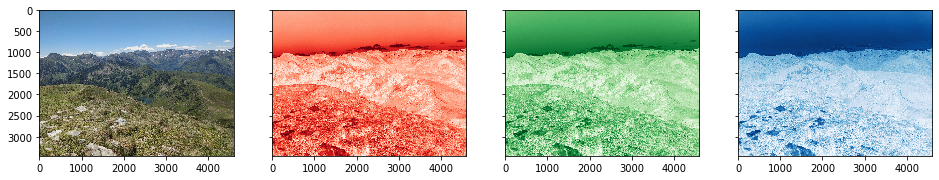

In [12]:
plot_img_channels(YCbCr_to_RGB(img_ycbcr))

On a bien l'opération inverse qui fonctionne.



On compare notre fonction avec la fonction du module Image de PIL :

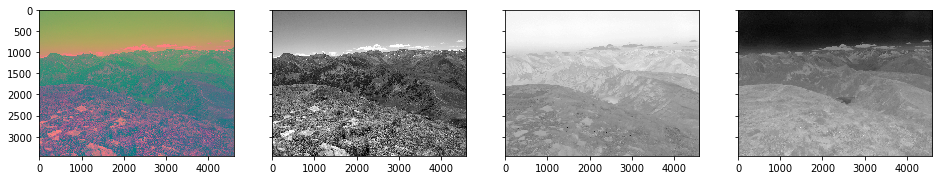

In [13]:
img_yuv = RGB_to_YCbCr_v2(img)

plot_img_channels(np.array(img_yuv), ['gray'] * 3)

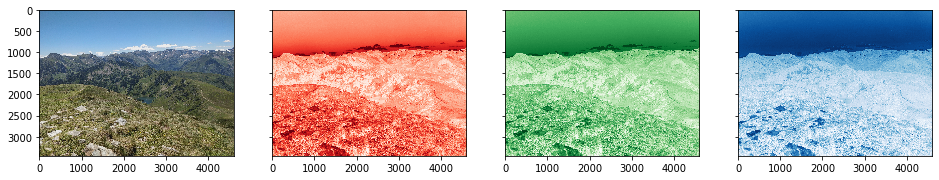

In [14]:
img_rgb = YCbCr_to_RGB_v2(img_ycbcr)

plot_img_channels(np.array(img_rgb))

### 2. Sous échantillonnage des couleurs

La deuxième étape de la compression est le sous échantillonnage des canaux de couleurs (Cb et Cr). On sépare les canaux. On ne touche pas au channel Y (la luminosité) mais on va rétrécir les image de U et V. Il y a plusieurs réglages possibles que l'on décrit avec la « notation J:a:b », définie ainsi, par bloc de 8x8 :
- J est le nombre de pixels de Y conservés pour 4 pixels affichés, sur chaque ligne ;
- a est le nombre de pixels de U conservés pour 4 pixels affichés, sur les lignes paires ;
- b est le nombre de pixels de V conservés pour 4 pixels affichés, sur les lignes impaires.


![subsampling](images_notebook/subsampling.png)

Ainsi le sous échantillonnage de couleur le plus utilisé est le 4:2:0 (c'est à dire qu'on découpe l'image en bloc de 8x8). (Mais ce n'est pas le plus important, on peut prendre du 4:4:4)

In [15]:
def subsampling_YCbCr(img_ycbcr):
    # 347 ms ± 4.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
    img_sub = np.copy(img_ycbcr)
    
    # Verticalement : tous les deuxièmes coefficients sont égaux au coefficient qu'il y a au dessus
    img_sub[1::2, :, 1:] = img_sub[::2, :, 1:]
    
    #Horizontalement : tous les deuxièmes coeff sont égaux au coeff à leur gauche
    img_sub[:, 1::2, 1:] = img_sub[:, ::2, 1:]
    
    return img_sub    

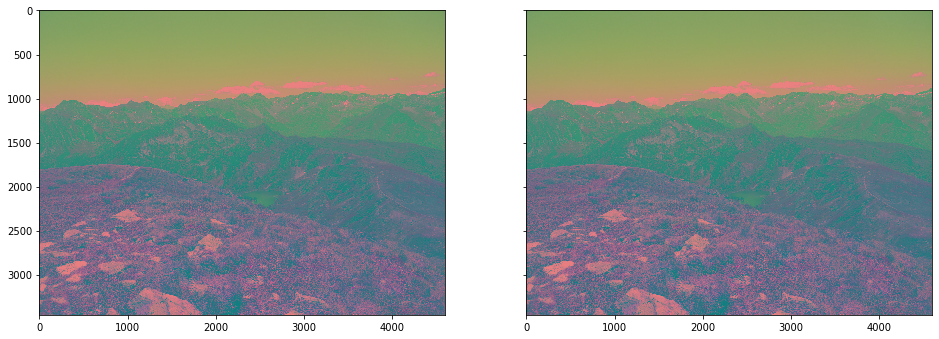

In [16]:
img_sub = subsampling_YCbCr(img_ycbcr)

plot_compare_imgs(img_ycbcr, img_sub)

On remarque que sur cette image (de taille $3456 \times 4608$), on n'observe pas de différence significative. 

Nous allons ensuite faire la différence entre l'image subsamplé et l'image originale pour déterminer si il y a beaucoup de perte d'informations.

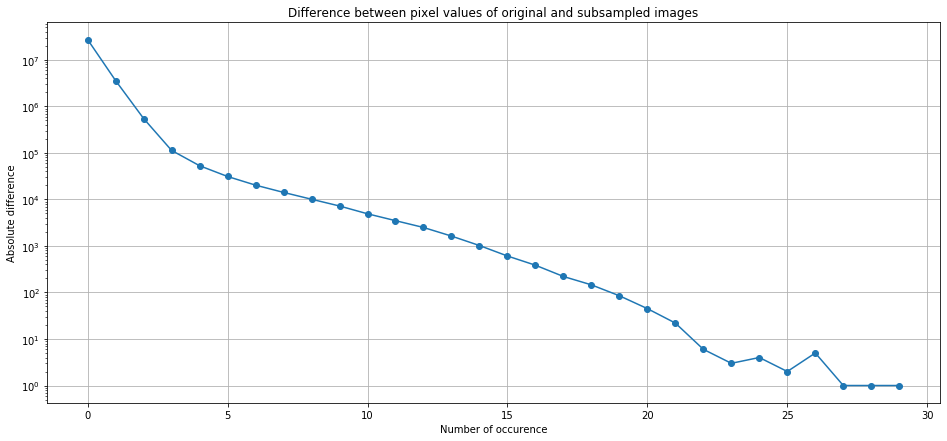

In [17]:
uniques, counts = np.unique(np.abs(img_sub[:,:,1:] - img_ycbcr[:,:,1:]),return_counts=True)

fig, ax = plt.subplots(figsize=(16, 7))
ax.semilogy(uniques, counts, 'o-')

ax.set(xlabel='Number of occurence', ylabel='Absolute difference',
       title='Difference between pixel values of original and subsampled images')
ax.grid()

### 3. Découpage de l'image en blocks


En JPEG, on ne travaille pas sur une image entière : on travaille sur des blocs de 8x8 pixels (séparément en ce qui concerne l’intensité, le bleu et le rouge, donc).
Si la taille d’une image n’est pas exactement un multiple de 8 dans un axe donné, et que
la compression est forte, de légers défauts de compression pourraient apparaître. C’est un des soucis de JPEG.

Chaque bloc de 8x8 est en suite envoyé pour être transformé par DCT.



Translation des coefficients de [0;255] à [-128;127]
On fait cette translation car on travaille avec la DCT.

In [18]:
def shift_array(arr, shift=-128):
    # 67.9 ms ± 834 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
    return arr + shift

In [19]:
img_shifted = shift_array(img_sub)

Implémentation de transform_into_blocks.
On va privilégier la version 2 qui est beaucoup plus rapide.

In [20]:
def transform_into_blocks(img, block_size=8):
    # 696 ms ± 14.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
    """
    Return a array of size (img.shape[0] // block_size, img.shape[1] // block_size, 3, block_size, block_size) or
                         (3, img.shape[0] // block_size, img.shape[1] // block_size, block_size, block_size) (TBD)
    First shape reads block from top to bottom, from left to right.
    """
    nb_blocks_height = img.shape[0] // block_size
    nb_blocks_width  = img.shape[1] // block_size

    blocks = np.empty((nb_blocks_height, nb_blocks_width, 3, block_size, block_size), dtype=img.dtype)

    for y in range(nb_blocks_height):
        for x in range(nb_blocks_width):
            for color in range(3):
                blocks[y, x, color] = img[y * block_size:(y + 1) * block_size, 
                                          x * block_size:(x + 1) * block_size, 
                                          color]

    return blocks


def transform_into_blocks_v2(img, block_size=8):
    # 6.45 µs ± 113 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)
    shape = img.shape
    pre_blocks = np.reshape(img, (shape[0] // block_size, block_size, 
                                  shape[1] // block_size, block_size, 
                                  3))
    
    blocks = np.moveaxis(pre_blocks, [0, 1, 2, 3, 4], [0, 3, 1, 4, 2])
    
    return blocks

On transforme l'image shifté en "blocks" qui contient les 432 x 576 blocs de 8x8 sur 3 channels de l'image. On pourra en suite travailler sur chaque bloc.

In [25]:
blocks = transform_into_blocks_v2(img_shifted)

In [26]:
blocks.shape

(432, 576, 3, 8, 8)

On affiche un bloc de blocks pour voir un aperçu des coefficients.

In [27]:
b1 = shift_array(blocks[0, 0, 1])
b1

array([[-102, -102, -102, -102, -102, -102, -102, -102],
       [-102, -102, -102, -102, -102, -102, -102, -102],
       [-101, -101, -101, -101, -101, -101, -101, -101],
       [-101, -101, -101, -101, -101, -101, -101, -101],
       [-100, -100, -100, -100, -100, -100, -100, -100],
       [-100, -100, -100, -100, -100, -100, -100, -100],
       [-100, -100, -100, -100, -100, -100, -100, -100],
       [-100, -100, -100, -100, -100, -100, -100, -100]])

Implémentation de transform_into_image (opération inverse))
De même, on va utiliser la version 2 qui est plus rapide.

In [28]:
def transform_into_image(blocks, block_size=8):
    # 768 ms ± 39.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
    """
    Return a array of size (img.shape[0] // block_size, img.shape[1] // block_size, 3, block_size, block_size) or
                         (3, img.shape[0] // block_size, img.shape[1] // block_size, block_size, block_size) (TBD)
    First shape reads block from top to bottom, from left to right.
    """
    img_height = blocks.shape[0] * block_size
    img_width  = blocks.shape[1] * block_size

    img = np.empty((img_height, img_width, 3), dtype=blocks.dtype)

    for i in range(blocks.shape[0]):
        for j in range(blocks.shape[1]):
            for color in range(3):
                img[
                    i * block_size : (i + 1) * block_size, 
                    j * block_size : (j + 1) * block_size, 
                    color,
                ] = blocks[i, j, color]

    return img

def transform_into_image_v2(blocks, block_size=8):
    # 6.53 µs ± 122 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)
    pre_img = np.moveaxis(blocks, [0, 3, 1, 4, 2], [0, 1, 2, 3, 4])
    
    shape = pre_img.shape
    img = np.reshape(pre_img, (shape[0] * shape[1], shape[2] * shape[3], 3))
    
    return img

A partir des blocs de "blocks" définit plus haut, on retourne à l'image d'origine qui est de dimension 3456x4608 avec 3 channels.

In [29]:
img_deblocked = transform_into_image_v2(blocks)

In [30]:
img_deblocked.shape

(3456, 4608, 3)

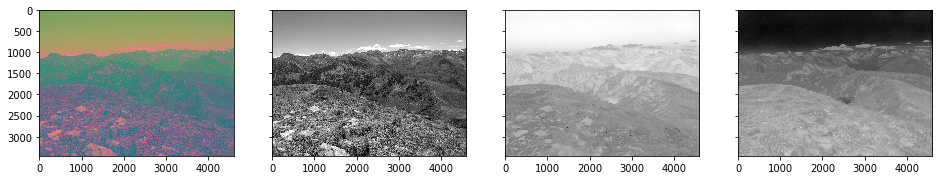

In [31]:
plot_img_channels(shift_array(img_deblocked, 128), ['gray'] * 3)

### 4. Transformée en cosinus discret 

On applique une DCT (Discrete Cosine Transform) à chaque bloc de l'image. On peut voir la DCT comme une variante de la transformation de Fourier. Cette transformation décompose un bloc (considéré comme une fonction numérique à deux variables) en une somme de fonction cosinus oscillant à des frequences différentes. Chaque bloc est ainsi décrit à l'aide de frequénce et d'amplitude plutôt qu'en pixels et coefficient de couleur. On va utiliser la DCT directement implémentée par la librairie fft.

Le calcul de la DCT est l'étape qui coûte le plus de temps et de ressources dans le processus de compression JPEG. Elle permet de séparer les basses et hautes frequences de l'image ce qui nous permet en suite de supprimer les informations non importantes jusqu'à un certain niveau de détail pendant la compression.  

In [32]:
dct1 = fft.dctn(b1)
dct1.shape, dct1.astype(int)

((8, 8),
 array([[-25792,      0,      0,      0,      0,      0,      0,      0],
        [  -140,      0,      0,      0,      0,      0,      0,      0],
        [   -41,      0,      0,      0,      0,      0,      0,      0],
        [     8,      0,      0,      0,      0,      0,      0,      0],
        [     0,      0,      0,      0,      0,      0,      0,      0],
        [    -5,      0,      0,      0,      0,      0,      0,      0],
        [    17,      0,      0,      0,      0,      0,      0,      0],
        [    27,      0,      0,      0,      0,      0,      0,      0]]))

On applique la dct sur le block b1 que l'on a affiché plus haut. On l'applique d'abord sans l'option norme puis avec. On constate une différence dans les coefficients. Plus tard on préferera utiliser la norme pour que dct(idct) donne bien la fonction identité. 

In [33]:
dct1 = fft.dctn(b1, norm='ortho')
dct1.shape, (dct1).astype(int)

((8, 8),
 array([[-806,    0,    0,    0,    0,    0,    0,    0],
        [  -6,    0,    0,    0,    0,    0,    0,    0],
        [  -1,    0,    0,    0,    0,    0,    0,    0],
        [   0,    0,    0,    0,    0,    0,    0,    0],
        [   0,    0,    0,    0,    0,    0,    0,    0],
        [   0,    0,    0,    0,    0,    0,    0,    0],
        [   0,    0,    0,    0,    0,    0,    0,    0],
        [   1,    0,    0,    0,    0,    0,    0,    0]]))

On définit une fonction qui applique la DCT à chaque bloc de blocks. 


In [34]:
def apply_dct(blocks):
    # 650 ms ± 18.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
    return fft.dctn(blocks, axes=[-2, -1], norm ='ortho')

In [35]:
blocks_dct = apply_dct(blocks)

In [36]:
blocks_dct.shape

(432, 576, 3, 8, 8)

Implémentation DCT inverse

In [37]:
def apply_idct(blocks):
    # 631 ms ± 9.37 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
    return np.round(fft.idctn(blocks, axes=[-2,-1], norm='ortho')).astype(np.float64)

In [38]:
blocks_idct = apply_idct(blocks_dct)

In [39]:
print(blocks_idct.shape)
print(blocks_idct[0, 0, 1])

(432, 576, 3, 8, 8)
[[26. 26. 26. 26. 26. 26. 26. 26.]
 [26. 26. 26. 26. 26. 26. 26. 26.]
 [27. 27. 27. 27. 27. 27. 27. 27.]
 [27. 27. 27. 27. 27. 27. 27. 27.]
 [28. 28. 28. 28. 28. 28. 28. 28.]
 [28. 28. 28. 28. 28. 28. 28. 28.]
 [28. 28. 28. 28. 28. 28. 28. 28.]
 [28. 28. 28. 28. 28. 28. 28. 28.]]


In [40]:
#blocks = np.random.randn(16, 16)
np.allclose(blocks, apply_idct(apply_dct(blocks)))

True

### 5. Quantification

C'est à cette étape que l'on perd l'information. On divise le bloc par la matrice de quantification ce qui nous permet de supprimer les hautes fréquences.

In [41]:
quantization_matrix = np.array([[16, 11, 10, 16,  24,  40,  51,  61],
                                [12, 12, 14, 19,  26,  58,  60,  55],
                                [14, 13, 16, 24,  40,  57,  69,  56],
                                [14, 17, 22, 29,  51,  87,  80,  62], 
                                [18, 22, 37, 56,  68, 109, 103,  77], 
                                [24, 35, 55, 64,  81, 104, 113,  92], 
                                [49, 64, 78, 87, 103, 121, 120, 101], 
                                [72, 92, 95, 98, 112, 100, 103,  99]], dtype=int)

In [42]:
def get_quant_matrix(Q=50):
    if Q == 50:
        return quantization_matrix
    
    elif Q > 50:
        return np.round(50 * quantization_matrix / Q)
    
    else:
        return np.round((100 - Q) * quantization_matrix / 50)

In [43]:
def quantize(arr, quant_mat=get_quant_matrix(Q=50)):
    # 311 ms ± 13.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
    return np.round(np.divide(arr, quant_mat)).astype(int)

def dequantize(arr, quant_mat=get_quant_matrix(Q=50)):
    # 141 ms ± 5.59 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
    return np.multiply(arr, quant_mat)

In [44]:
blocks_quant = quantize(blocks_dct)

In [45]:
blocks_quant[0, 0, 1]

array([[14,  0,  0,  0,  0,  0,  0,  0],
       [-1,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0]])

In [46]:
blocks_dequant = dequantize(blocks_quant)

In [47]:
img_deblocked = transform_into_image(apply_idct(blocks_dequant))
img_deblocked.shape

(3456, 4608, 3)

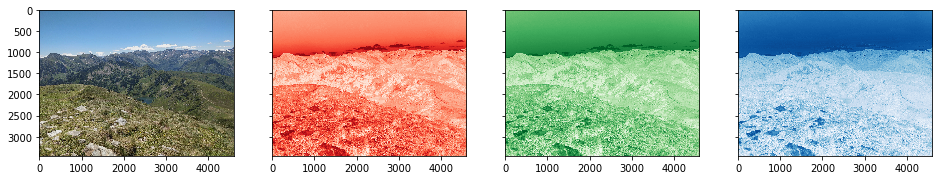

In [48]:
plot_img_channels(YCbCr_to_RGB(shift_array(img_deblocked, 128)))

### 6. Codage RLE et Huffman 


On va calculer les entropies des DCT.
L'entropie permet de mesurer le nombre de bit nécessaire pour coder l'information de la DCT.
D'abord on doit aplatir les blocks 8x8 de l'image en vecteurs ligne, en prenant les coefficient en zigzag selon l'image suivante :

![zigzag](images_notebook/zigzag.png)

On va calculer l'entropie pour la DCT de chaque block aplatis selon le zigzag. 
- Il nous faut une fonction bloc_to_zigzag (RLE) renvoyant une ligne de 64 ;
- Les lignes zigzag s'arrêtent avec un signal "end of block" à définir, qui détermine à partir de quel coefficient le vecteur n'est rempli plus que de zéros
- Une fonction qui prend toutes les lignes zigzag correspondant à tous les blocs de l'image, qui sélectionne le premier coeff de chaque ligne pour les mettre dans un vecteur "premiers coeffs" et qui sélectionne tous les autres vecteurs pour les mettre dans un vecteurs "autres coeffs".

L'entropie (de Shannon) est définie par :

$$E(\pi) = - \sum_i \pi(\alpha_i) \log_2 \Big( \pi(\alpha_i) \Big) $$

Où $\pi$ est la loi de probabilité d'apparition de chaque coefficient.


Tout d'abord, voici la fonction qui transforme un block $8 \times 8$ en zigzag: 

In [85]:
def RLE(block):
    block_rot = np.rot90(block)
    flat_array = []
    
    n = block.shape[0]
    for i in range(-n + 1, n):
        flat_array += list(np.diagonal(block_rot, offset=i))[::(i % 2) * (-2) + 1]
    
    arr = np.array(flat_array, dtype=int)    
    return arr

In [86]:
rle = RLE(blocks_quant[0, 0, 1])
rle

array([14,  0, -1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0])

In [88]:
def RLE_v2(blocks):
    blocks_rot = np.rot90(blocks, axes=(-2, -1))
    shape = blocks.shape
    n = shape[-1]
    
    flat_array = np.empty((*shape[:-2], n**2), dtype=int)
    
    idx = 0
    for i in range(-n + 1, n):
        length_diag = n - abs(i)
        diag = np.copy(np.diagonal(blocks_rot, offset=i, axis1=-2, axis2=-1))
        
        if i % 2 == 1:
            diag = np.flip(diag, axis=-1)
        flat_array[..., idx:idx + length_diag] = diag
        idx += length_diag
    
    return flat_array

In [89]:
rles_v2 = RLE_v2(blocks_quant)
rles_v2[..., 0].shape, rles_v2[0, 0, 1]

((432, 576, 3),
 array([14,  0, -1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0]))

In [90]:
np.trim_zeros(rles_v2[0, 0, 1], trim='b')

array([14,  0, -1])

In [91]:
%timeit np.concatenate((np.trim_zeros(np.zeros(64, dtype=int), trim='b'), [0, 'EOB']))
%timeit np.append(np.trim_zeros(np.zeros(64, dtype=int), trim='b'), [0, 'EOB'])

86.3 µs ± 2.01 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)
85.2 µs ± 1.38 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


Le prochain objectif est de 'tailler' chaque ligne des zéros à droite.

In [92]:
def put_EOB(ligne): #coupe le vecteur là où les 0 commencent et ajoute le EOB
#     CPU times: user 13.5 s, sys: 99.5 ms, total: 13.6 s
    size = ligne.size
    i = size-1
    while ligne[i] == 0 and i > 0:
            i -= 1
    new_ligne = ligne[:i+1].tolist()
    new_ligne += ['EOB']
    return new_ligne

In [93]:
put_EOB(rles_v2[0, 0, 1]), put_EOB(np.zeros(64, dtype=int))

([14, 0, -1, 'EOB'], [0, 'EOB'])

In [98]:
%%time
new_lines = []
for line in rles_v2.reshape(np.prod(rles_v2.shape[:-1]), rles_v2.shape[-1]):
    new_lines.append(put_EOB(line))

CPU times: user 13.1 s, sys: 99.1 ms, total: 13.2 s
Wall time: 13.2 s


In [99]:
#test
ligne_1 = np.array([1,2,3,0,0,4,1,2,0,0,0,0,0])
ligne_2 = np.array([2,0,0,1,4,0,0,0,0,0,0,0,0])
ligne_3 = np.array([0,0,0,0,0,0,0,0,0,0,0,0,0])
new_ligne_1 = put_EOB(ligne_1)
new_ligne_2 = put_EOB(ligne_2)
new_ligne_3 = put_EOB(ligne_3)
print(new_ligne_1)
print(new_ligne_2)
print(new_ligne_3)
put_EOB(rle)

[1, 2, 3, 0, 0, 4, 1, 2, 'EOB']
[2, 0, 0, 1, 4, 'EOB']
[0, 'EOB']


[14, 0, -1, 'EOB']

On créer ensuite "l'alphabet" des coefficients en séparant le premier coefficient de chaque ligne des autres.

In [114]:
def alphabet(all_ligne):
    premiers_coeffs = []
    autres_coeff = []
    
    for i in range(len(all_ligne)):
        premiers_coeffs += [all_ligne[i][0]]
        autres_coeff += all_ligne[i][1:]
        
    return premiers_coeffs, autres_coeff

In [115]:
lignes_test = [put_EOB(ligne) for ligne in rles_v2[0, 0]]

alphabet(lignes_test)

([-8, 14, -13], ['EOB', 0, -1, 'EOB', 'EOB'])

On calcule après la probabilité d'apparition de chaque coefficient (en prenant en compte le `'EOB'`). Puis enfin l'entropie totale du système.

In [116]:
def distribution_coeff(arr):  
    nb_pixel = len(arr)
    coeffs, counts = np.unique(arr, return_counts=True)
    distribution = counts / nb_pixel
    return coeffs, distribution, nb_pixel

#calcule l'entropie
def entropie(arr):
    coeffs, distribution, nb_pixel = distribution_coeff(arr)
    
    E = -np.sum(distribution * np.log2(distribution))
    return E

In [129]:
def entropy_dct(blocks):
    shape = blocks.shape
    rles = np.empty(shape[:-2] + (np.prod(shape[-2:]),))
    rles = RLE_v2(blocks)
    after_EOB = []
    
    for i, j, c in product(*map(range, shape[:3])):
        after_EOB.append(put_EOB(rles[i, j, c]))
    
    first_coeffs, other_coeffs = alphabet(after_EOB)
    entropy_1 = entropie(first_coeffs)
    entropy_2 = entropie(other_coeffs)
    
    return entropy_1, entropy_2, len(first_coeffs), len(other_coeffs)

In [126]:
%%time
entropy_dct(blocks_quant)

CPU times: user 14.5 s, sys: 217 ms, total: 14.7 s
Wall time: 14.8 s


(5.654737933879029, 3.0572670712050547, 746496, 4989872)

In [131]:
def get_theoretical_size_raw(s, e=8):
    return s * e

def get_theoretical_size_compressed(s1, s2, e1, e2):
    bits = int(s1 * e1) + int(s2 * e2) + 2
    return  bits

def print_theo(size_bits, type_img):
    return f'{type_img} : {size_bits / 1_000:.0f} kbits '

### 7. From image to jpeg

In [132]:
def to_JPEG(img, Q=50):
    # 5.91 s ± 21.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
    """Compress and return a JPEG image"""
    T = get_quant_matrix(Q=Q)
    
    img = RGB_to_YCbCr(img)
    img = subsampling_YCbCr(img)
    img = shift_array(img, shift=-128)
    
    blocks = transform_into_blocks(img)
    blocks = apply_dct(blocks)
    blocks = quantize(blocks, T)
    
    blocks = dequantize(blocks, T)
    blocks = apply_idct(blocks)
    
    img = transform_into_image(blocks)
    img = shift_array(img, shift=128)
    img = YCbCr_to_RGB(img)
    
    return img

def to_JPEG_v2(img, get_entropy=False, Q=50):
    # 2.21 s ± 11.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
    """Compress and return a JPEG image"""
    T = get_quant_matrix(Q=Q)
    
    img = RGB_to_YCbCr_v2(img)
    img = subsampling_YCbCr(img)
    img = shift_array(img, shift=-128)

    blocks = transform_into_blocks_v2(img)
    blocks = apply_dct(blocks)
    blocks = quantize(blocks, T)
    
    size_comp = get_theoretical_size_compressed(*entropy_dct(blocks))
    size_raw = get_theoretical_size_raw(img.size)
    
    if get_entropy:
        print(' ' * 4, print_theo(size_comp, 'COMP'))
        print(' ' * 4, print_theo(size_raw, 'RAW'))
        print(' ' * 4, f'Reduction of {abs(size_comp - size_raw) / size_raw : .1%}')
    
    blocks = dequantize(blocks, T)
    blocks = apply_idct(blocks)
    
    img = transform_into_image_v2(blocks)
    img = shift_array(img, shift=128)
    img = YCbCr_to_RGB_v2(img)
    
    return img

In [133]:
def MSE(img_ref, img):
    size = img_ref.size
    return np.sum((img_ref - img)**2) / size

def PSNR(img_ref, img):
    return 20 * np.log10(255) - 10 * np.log10(MSE(img_ref, img))

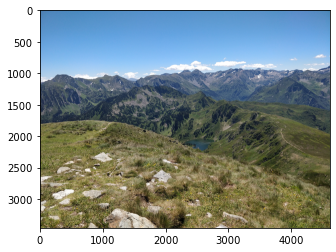

In [134]:
img_RAW = np.copy(img)
plt.imshow(img_RAW)

In [135]:
img_JPEG = to_JPEG_v2(img_RAW, get_entropy=True)

     COMP : 21339 kbits 
     RAW : 382206 kbits 
     Reduction of  94.4%


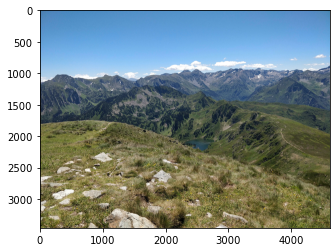

In [136]:
plt.imshow(img_JPEG)

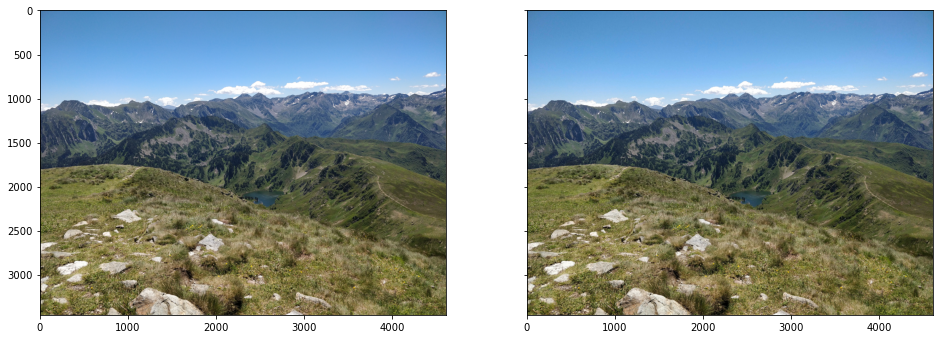

In [137]:
plot_compare_imgs(img_RAW, img_JPEG)

In [138]:
PSNR(img_RAW, img_JPEG)

32.90530866640454

In [ ]:
for Q in [0, 50, 100]:
    img_JPEG = to_JPEG_v2(img_RAW, get_entropy=True, Q=Q)
    psnr = PSNR(img_RAW, img_JPEG)
    print(f"Facteur de qualite {Q:>3d}, PSNR = {psnr:.2f} dB")

| Quality factor | Size Raw (Mb) | Size Comp (Mb) | Reduction |
|:--------------:|:-------------:|:--------------:|:---------:|
|        0       |     382.2     |      14.1      |   96.3%   |
|       50       |     382.2     |      21.3      |   94.4%   |
|       100      |     382.2     |      31.8      |   91.7%   |

## II. Estimation du mouvement

In [ ]:
import numpy as np
import numpy.linalg as npl
from scipy import signal
from scipy import interpolate
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib as mpl
import time
import copy
import warnings
import scipy.signal as scs
warnings.filterwarnings('ignore')
import cv2

Le principe de la compression par estimation de mouvement ou "block matching" est de découper 2 images consécutives en blocs de tailles égales puis de trouver les déplacements de chaque bloc d'une image à l'autre.

En procedant ainsi on remplace une image par une matrice des vecteurs déplacement, de taille moins lourde.

D'un point de vue pratique, on définit une zone de recherche dans notre image de référence dans laquelle on va essayer de situer un bloc issu de l'image à prédire. 

La première étape de l'estimation de mouvement consiste donc à définir les paramètres de l'algorithme qui sont :
* La taille des macroblocs, ou "block size"
* La marge, ou "padding", qui définit la définit de la zone de recherche

In [ ]:
## Paramètres
p = 7
bs = 16
## Norme utilisée pour calculer la similarité
similarity_metric = "SSD" # Dispo ("CORR", "FRO", "SAD", "SSD")
# Paramètre debug qui permet d'étudier le calcul du déplacement bloc par bloc
debug = False
# Ouverture des images
img_t = np.array(Image.open("img/1.jpg"))[:,:,0]
img_tp1 = np.array(Image.open("img/2.jpg"))[:,:,0]

L'étape centrale de l'algorithme consiste à parcourir les blocs de l'image à prédire et d'effectuer le calcul du vecteur déplacement entre le bloc de l'image à predire et l'image de référence. La fonction encode_motion retourne un tableau de vecteurs déplacement qu'on utilise pour le décodage.

In [ ]:
def encode_motion(iref, ipred, bs, p, metric, debug):
    """
    Parcours des blocs et calcul du déplacement
    """
    n, m = np.shape(ipred)[:2]
    ncol = int(m // bs)
    nrow = int(n // bs)
    u = np.zeros((nrow*ncol, 2))
    f = 2 * p + 1
    print(">> Similarity metric used : ",metric)
    print(f">> {nrow * ncol} blocs | {int((bs + 2 * p) // (bs/f) - (f - 2))**2} comparaisons par bloc")
    if debug :
        nrow = 1
    for i in range(nrow):
        for j in range(ncol):
            search_zone = iref[i * bs : (1 + i) * bs + 2 * p, j * bs : (1 + j) * bs + 2*p]
            block = ipred[i * bs : (1 + i) * bs, j * bs : (j + 1) * bs]
            u[i * ncol + j, 0], u[i * ncol + j, 1] =  calcul_deplacement(search_zone, block, bs, p, metric, debug)
            if debug == True and j == 4:
                break
            if ((i * ncol + j) / (nrow * ncol) * 100 ) % 10 == 0:
                print(f'Progression : {(i * ncol + j) / (nrow * ncol) * 100 }%')
    print("Déplacement moyen sur toute l'image :", np.mean(u[:,0]), np.mean(u[:,1]))
    return u

Pour calculer le déplacement entre le macrobloc de l'image à prédire et le bloc de l'image de référence, il n'y a pas de contrainte dans le standard MPEG. Dans notre cas on utilise la méthode la plus basique, c'est à dire la recherche exhaustive. La recherche exhaustive consiste simplement à tester toutes les positions possibles du macrobloc dans la zone de recherche. Par exemple dans le cas ou la taille du macrobloc est de 16x16 et le padding est de 7px, il y a 255 positions à tester.

![Capture d’écran de 2021-01-06 15-17-09.png](attachment:b1fea0d1-c40e-49ba-9a26-68906a2ca67b.png)

In [ ]:
def calcul_deplacement(search_zone, block, bs, p, metric, debug):
    """
    Recherche exhaustive sur la zone de recherche et calcul de la similarité
    
    Normes disponibles pour le calcul de similarité :
    * Frobenius 
    * Sum of Squared Differences (SSD)
    * Sum of Absolute Differences (SAD)
    * Correlation
    
    """
    
    # Variables
    n,m = np.shape(search_zone)
    s = 1 # stride (inutile)
    f = 2 * p + 1 # facteur de recouvrement
    ncol = int(m // (bs/f) - (f - 2))
    nrow = int(n // (bs/f) - (f - 2))    
    
    if metric == "CORR":
        # Normalisation (en phase de test)
        search_zone = search_zone.astype('float32')
        block = block.astype('float32')
        search_zone -= search_zone.mean()
        search_zone = search_zone / search_zone.std()
        block -= block.mean()
        block = block / block.std()
        # Calcul de similarité avec la corrélation (fait le parcours exhaustif automatiquement)
        corr = signal.correlate2d(search_zone,block, "valid") # Valid important !
        y, x = np.unravel_index(np.argmax(corr), corr.shape) # Trick python pour trouver le max d'une matrice
        n2, m2 = corr.shape
        # Recentrage pour obtenir le vecteur déplacement
        y_opti = y - n2//2
        x_opti = x - m2//2

        if debug:
            # Affichage du bloc selectionné par la corrélation
            fig, ax = plt.subplots(1,3, figsize=(18,7))
            ax[0].imshow(search_zone)
            ax[0].scatter(x_opti+ bs//2 + p, y_opti+ bs//2 + p, c="r")
            rect = patches.Rectangle( (x, y) ,bs,bs,linewidth=1,edgecolor='k',facecolor='none')    
            ax[0].add_patch(rect)
            ax[1].imshow(block)
            ax[1].scatter(bs // 2, bs // 2, c='r')
            ax[2].imshow(corr)
            plt.show()
            print("Cordonnées du max de corrélation :", y, x)
            print("Coordonnées du déplacement optimal recentré", x_opti, y_opti)
            input()
        
    else :
        # Cas général
        # On fait le parcours manuellement et on calcul la similarité avec la norme 2

        CF = np.zeros((nrow * ncol, 3)) # On garde les résultats de chaque position testées en mémoire ici

        for i in range(nrow) :
            for j in range(ncol) :
                # On se repère par rapport au centre du bloc
                x_mid_block, y_mid_block = int((j/f) * bs + bs // 2 ) , int((i/f) * bs + bs // 2)
                left = x_mid_block - (bs//2)
                right = x_mid_block + (bs//2)
                down = y_mid_block - (bs//2)
                up = y_mid_block + (bs//2)
            
                # Calcul de la similarité avec différentes normes
                img = block - search_zone[left:right , down:up]
                
                if metric == "FRO" :
                    cost = npl.norm(img, "fro")                    
                elif metric == "SAD" :
                    cost = np.sum(np.abs(img))
                elif metric == "SSD" : # Correspond à la norme de frobenius mais avec une normalisation wtf de numpy sur le carré
                    cost = np.sqrt(np.sum(img**2))
                    
                # Remplissage du tableau de mémoire
                # Conversion milieu du bloc vers milieu de la zone de recherche -> on obtient le déplacement testé
                CF[i * ncol + j, 0] = y_mid_block - bs//2 - p 
                CF[i * ncol + j, 1] = x_mid_block - bs//2 - p 
                CF[i * ncol + j, 2] = cost

        if np.max(CF[:,2]) == np.min(CF[:,2]):
            # Si norme constante sur toutes les positions on choisi un déplacement de 0 manuellement
            x_opti, y_opti = 0, 0
        else : 
            id_min = np.argmin(CF[:,2])
            x_opti = CF[id_min, 0]
            y_opti = CF[id_min, 1]
        
        if debug:
            show_displacement(search_zone, block, p, CF, id_min)
            print("Coordonnées du déplacement optimal recentré", x_opti, y_opti)
            input()
    return x_opti, y_opti

In [ ]:
def decode_motion(iref, ipred, u, bs, p):
    """
    Reconstruit une image à partir d'un tableau de déplacement et d'une image de référence.
    """
    n, m = np.shape(ipred)[:2]
    ncol = int(m // bs)
    nrow = int(n // bs)
    decoded = np.zeros(ipred.shape)
    for i in range(nrow):
        for j in range(ncol):
            ux = u[i * ncol + j, 0]
            uy = u[i * ncol + j, 1]
            iref_motioned = np.roll(np.roll(iref,-int(round(uy)),axis=0),-int(round(ux)),axis=1)
            decoded[i * bs :bs * (1 + i),j * bs :bs * (j + 1)] = iref_motioned[p + i * bs: p+ bs * (1 + i),p + j * bs :p + bs * (j + 1)]
    return decoded

Dans la fonction suivante (Proof Of Concept), on combine toutes les fonctions décrites ci-dessus pour encoder une image, la reconstruire et étudier l'erreur de reconstruction

In [ ]:
def POC(im_t, im_tp1, bs, p, metric, debug = False):
    n,m = np.shape(im_t)
    # On rogne l'image pour tomber juste avec la taille macroblock choisie
    n_crop = n // bs  * bs
    m_crop = m // bs  * bs
    # Le flip sert juste à avoir un affichage dans le bon sens pour plt.imshow
    img_t_flipped_cropped = np.flip(im_t[:n_crop,:m_crop], axis = 0)
    img_tp1_flipped_cropped = np.flip(im_tp1[:n_crop,:m_crop], axis = 0)
    # On ajoute le padding à l'image de référence (constant égal à 0)
    iref = cv2.copyMakeBorder(img_t_flipped_cropped, p,p,p,p, cv2.BORDER_CONSTANT)
    n,m = np.shape(iref)
    ipred = np.copy(img_tp1_flipped_cropped)
    print('> Encoding ...')
    u = encode_motion(iref, ipred, bs, p, metric, debug)
    print(">>> Done")
    if not debug:
        print('> Decoding ...')
        decoded = decode_motion(iref, ipred, u, bs, p)
        fig, ax = plt.subplots(2,1, figsize = (20,28))
        ax[0].pcolormesh(ipred-decoded).set_cmap("magma")
        ax[0].set_title('Erreur (pas absolue)')
        ax[1].pcolormesh(decoded)
        ax[1].set_title("Image prédite")
        print(">>> Norme de l'erreur", npl.norm(ipred-decoded))
        
    else: 
        decoded = None
    return decoded, ipred

In [ ]:
def show_displacement(search_zone, block, p, CF, id_min):
    """
    Outil de débuggage : 
    Permet de regarder quel est le déplacement optimal obtenu pour chaque bloc
    pendant le calcul du déplacement
    """
    # Conversion milieu de la zone de recherche vers milieu du bloc
    x_opti = CF[id_min, 0] + bs//2 + p
    y_opti = CF[id_min, 1] + bs//2 + p
    n,m = np.shape(search_zone)

    fig, ax = plt.subplots(1,2, figsize=(14,4))
    ## Search Zone
    ax[0].pcolormesh(search_zone)
    ax[0].set_title(f"Zone de recherche {search_zone.shape} | COST = {CF[id_min, 2]:.2f} | Position # {id_min}")
    ax[0].scatter(x_opti , y_opti, c= 'r')
    rect = patches.Rectangle( (x_opti - bs // 2 , y_opti - bs // 2) ,bs,bs,linewidth=1,edgecolor='k',facecolor='none')    
    horiz_bar = patches.Rectangle( (x_opti, 0), 0, n, edgecolor="r")
    vert_bar = patches.Rectangle( (0, y_opti), m, 0, edgecolor="r")
    ax[0].add_patch(horiz_bar)
    ax[0].add_patch(vert_bar)
    ax[0].add_patch(rect)
    
    ## Block
    ax[1].pcolormesh(block)
    ax[1].set_title(f"Bloc à situer | Size : {block.shape}")
    ax[1].scatter(bs//2, bs//2, c='r')
    horiz_bar = patches.Rectangle( (0, bs//2), bs, 0, edgecolor="r")
    vert_bar = patches.Rectangle( (bs//2, 0), 0, bs, edgecolor="r")
    ax[1].add_patch(horiz_bar)
    ax[1].add_patch(vert_bar)
    
    plt.suptitle(f"Déplacement : {CF[id_min, 0]}, {CF[id_min, 1]}", fontsize=12)

    ## Pour afficher toutes les position sur la search zone
    #     rect = patches.Rectangle( (int((j/f) * bs), int((i/f) * bs)) ,bs,bs,linewidth=1,edgecolor='k',facecolor='none')
    #     ax[0].scatter(int((j/f) * bs + bs // 2 ) , int((i/f) *bs + bs // 2), c= 'r')


    plt.show()

In [ ]:
decoded, ipred = POC(img_t, img_tp1, bs, p, similarity_metric, debug)

**Remarque** : En utilisant la norme de Frobenius, le résultat est le suivant. Cette norme n'est pas du tout adapté à ce type de problème.

In [ ]:
decoded, ipred = POC(img_t, img_tp1, bs, p, "FRO", debug)

## Bloc par bloc

On observe ici le déroulement du calcul du déplacement optimal. Sur l'image de gauche on affiche la zone de recherche et on marque par un carré noir l'emplacement du macrobloc, affiché à droite, d'après la mesure de similarité.

On affiche 5 exemples ci-dessous.

In [ ]:
img_t = np.array(Image.open("img/dbz_1_1.png"))[:,:,0]
img_tp1 = np.array(Image.open("img/dbz_1_2.png"))[:,:,0]
decoded, ipred = POC(img_t, img_tp1, bs, p, "SSD", debug = True)

### Version finale

On itère le processus sur les 3 canaux de l'image et on obtient le résultat suivant

In [ ]:
def seq2mpeg(frame1, frame2, bs, p):
    """
    Calcul du déplacement sur les 3 canaux indépendemment et reconstruction de l'image prédite 
    au format RGB
    """
    n,m,c = np.shape(frame1)
    n_crop = n // bs  * bs
    m_crop = m // bs  * bs
    RGB = []
    for i in range(3):
        print(f'> Canal {i}...')
        
        frame1_i = frame1[:,:,i]
        frame2_i = frame2[:,:,i]
        # Flip pour l'affichage avec imshow dans le bon sens
        frame1_flipped_cropped = np.flip(frame1_i[:n_crop,:m_crop], axis = 0)
        frame2_flipped_cropped = np.flip(frame2_i[:n_crop,:m_crop], axis = 0)
        # Ajout du padding à la frame de réference
        frame_ref = cv2.copyMakeBorder(frame1_flipped_cropped, p,p,p,p, cv2.BORDER_CONSTANT)
        n,m = np.shape(frame_ref)
        frame_to_predict = np.copy(frame2_flipped_cropped)

        print('> Encoding ...')
        u = encode_motion(frame_ref, frame_to_predict, bs, p, "SSD", False)
        print(">>> Done")
        decoded = decode_motion(frame_ref, frame_to_predict, u, bs, p)
        RGB.append(decoded)
    fig, ax = plt.subplots(1,1, figsize = (15,10))
    plt.imshow(np.flip(np.dstack(RGB).astype(np.uint8), axis = 0))
    return RGB

In [ ]:
frame1 = np.array(Image.open("img/1.jpg"))
frame2 = np.array(Image.open("img/2.jpg"))
RGB = seq2mpeg(frame1, frame2, 16, 7)

In [ ]:
fig, ax = plt.subplots(1,1, figsize = (15,10))

plt.imshow(frame2)
plt.title("Image réelle")
plt.show()

## Démonstration avec d'autres séquences


In [ ]:
frame1 = np.array(Image.open("img/dbz_1_1.png"))
frame2 = np.array(Image.open("img/dbz_1_2.png"))

RGB = seq2mpeg(frame1, frame2, 16, 7)

In [ ]:
fig, ax = plt.subplots(1,1, figsize = (15,10))

plt.imshow(frame2)
plt.title("Image réelle")
plt.show()

In [ ]:
frame1 = np.array(Image.open("img/dbz_2_1.png"))
frame2 = np.array(Image.open("img/dbz_2_2.png"))
RGB = seq2mpeg(frame1, frame2, 16, 7)

In [ ]:
fig, ax = plt.subplots(1,1, figsize = (15,10))

plt.imshow(frame2)
plt.title("Image réelle")
plt.show()

In [ ]:
frame1 = np.array(Image.open("img/dbz_3_1.png"))
frame2 = np.array(Image.open("img/dbz_3_2.png"))
RGB = seq2mpeg(frame1, frame2, 16, 7)

In [ ]:
fig, ax = plt.subplots(1,1, figsize = (15,10))

plt.imshow(frame2)
plt.title("Image réelle")
plt.show()

## Calcul du taux de compression

On retrouve le taux de compression à partir de la taille des images de la séquence des images que l'on veut compresser et la taille du macrobloc.

Avec une taille de macrobloc 16x16, on compresse l'image 8 fois car on remplace chaque bloc de 16x16 pixels par un vecteur de taille 2 (en supposant que les espaces mémoires alloués soient de même taille pour les pixels et les vecteurs déplacements)

Au final, si on décide de n'utiliser que 3 I-frames par secondes, on se retrouve avec 21 P-frames.

In [ ]:
(21 * 0.125 * 1 + 0.02 * 3)/24